## Conclusion from SQL and panda pre analysis
### Observation
* The code of a control area is unique. A control area will only have one unit and multiple SCPs but units may be duplicate among stations. Linename is messy. => Just use Control Area
* Time is not consistent too. => Use morning/afternoon/night...
* Get needed columns to save almost 100 mb
* Can keep desc-recovered but will need to clean duplicate data with both regular and recovered

### Completed
* Query data from database
* Clean duplicate data with both regular and recovered
* Create datetime frame
* Substract entries and exits to get the numbers
* Clean data
* Substract entries and exits by time
* Daily data analysis
* MVP
* Busiest CA and Time analysis

### To do
* Add linenames with statios to get the correct stations
* Recheck the result

# 1. Data Preparation

In [1]:
#*****need to run*****
from sqlalchemy import create_engine
#from sqlalchemy import inspect
import pandas as pd
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
#*****need to run*****
engine = create_engine("sqlite:///mta.db")

In [3]:
#*****need to run*****
#more sql queries in mta_eda_1_sql.ipynb
#df = pd.read_sql('SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data;', engine)
df = pd.read_sql('''SELECT ca, scp, station, linename, date, time, desc, entries, exits FROM mta_data
                    WHERE date NOT IN ("02/27/2021", "02/28/2021", "06/01/2021", 
                                       "06/02/2021", "06/03/2021", "06/04/2021")
                    ORDER BY ca, date, time, scp, desc;''', engine)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747757 entries, 0 to 2747756
Data columns (total 9 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CA        object
 1   SCP       object
 2   STATION   object
 3   LINENAME  object
 4   DATE      object
 5   TIME      object
 6   DESC      object
 7   ENTRIES   int64 
 8   EXITS     int64 
dtypes: int64(2), object(7)
memory usage: 188.7+ MB


In [5]:
#*****need to run*****
df["o_index"] = df.index
df["o_index"]
#drop duplicate data with wrong recover audit first
mask_dup = df[(df["o_index"] == 300706) |
          (df["o_index"] == 1089956) |
          (df["o_index"] == 1382146) |
          (df["o_index"] == 1382154) |
          ((df["CA"] == "N100") &
           (df["SCP"] == "00-00-00") &
           (df["ENTRIES"] == 818272) &
           (df["o_index"] != 842617))].index
df.drop(mask_dup, inplace= True)
#then, drop duplicate data with wrong regular data
df.drop_duplicates(subset=["CA", "SCP", "STATION", "DATE", "TIME"], keep= 'last', inplace=True)
df.drop(['o_index'], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
#datatime series
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df["DAY"] = df["DATE_TIME"].dt.weekday
#period calculation
df.sort_values(["CA", "SCP","DATE_TIME"], inplace=True)
df["PRE_ENTRIES"] = df.ENTRIES.shift(1)
df["PRE_EXITS"] = df.EXITS.shift(1)
df["PRE_TIME"] = df.DATE_TIME.shift(1)
df["PERIOD_ENTRIES"] = df.ENTRIES.diff(1)
df["PERIOD_EXITS"] = df.EXITS.diff(1)
#clean data
df.dropna(inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] < 0) | (df["PERIOD_EXITS"] < 0)].index, inplace=True)
df.drop(df[(df["DATE_TIME"] < df["PRE_TIME"])].index, inplace=True)
df.drop(df[((df["CA"] == "PTH03") & (df["SCP"] == "00-01-08") & (df["PRE_EXITS"] == 0.0))].index, inplace=True)
df.drop(df[(df["DATE_TIME"] - df["PRE_TIME"] > timedelta(days = 1))].index, inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] > 10000) | (df["PERIOD_EXITS"] > 10000)].index, inplace=True)
df["PERIOD_VISITS"] = df["PERIOD_ENTRIES"] + df["PERIOD_EXITS"]
df.reset_index(drop = True, inplace = True)
df[["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]] = (
    df[["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].astype(int))

#Combine station and linename, linename need to be sorted to avoid duplicated
df["LINENAME"].replace("123ACE", "123", inplace=True) #linename 123ACE should belong to linename 123 at Penn Station
def str_sort(line):
    """sort the string"""
    line_list = sorted(list(line))
    return "".join(line_list)
df["LINENAME_FIX"] = df.LINENAME.apply(str_sort)
df["STATION"] = df["STATION"] + "(" + df["LINENAME_FIX"] + ")"

In [6]:
df1 = pd.read_sql('''SELECT * FROM mta_data''', engine)
df1["CA_UNIT"] = df1["CA"] + df1["UNIT"]
for col in df1:
    print(col, df1[col].nunique())

CA 750
UNIT 469
SCP 224
STATION 379
LINENAME 114
DIVISION 6
DATE 98
TIME 58311
DESC 2
ENTRIES 1907237
EXITS 1808151
CA_UNIT 750


In [7]:
df.head(3)

,CA,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY,PRE_ENTRIES,PRE_EXITS,PRE_TIME,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,LINENAME_FIX
0,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,07:00:00,REGULAR,7537862,2570742,2021-03-01 07:00:00,0,7537860.0,2570718.0,2021-03-01 03:00:00,2,24,26,456NQRW
1,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,11:00:00,REGULAR,7537914,2570858,2021-03-01 11:00:00,0,7537862.0,2570742.0,2021-03-01 07:00:00,52,116,168,456NQRW
2,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,15:00:00,REGULAR,7538016,2570907,2021-03-01 15:00:00,0,7537914.0,2570858.0,2021-03-01 11:00:00,102,49,151,456NQRW


In [8]:
df.describe()

,ENTRIES,EXITS,DAY,PRE_ENTRIES,PRE_EXITS,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
count,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06
mean,2.916385e+07,2.167306e+07,2.967840e+00,2.916380e+07,2.167300e+07,5.244576e+01,5.704746e+01,1.094932e+02
std,1.688733e+08,1.421759e+08,2.009990e+00,1.688733e+08,1.421759e+08,7.756442e+01,9.111144e+01,1.413103e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.132380e+05,8.959400e+04,1.000000e+00,2.132050e+05,8.955100e+04,2.000000e+00,4.000000e+00,1.000000e+01
50%,1.405713e+06,8.381460e+05,3.000000e+00,1.405659e+06,8.380980e+05,2.100000e+01,2.300000e+01,5.800000e+01
75%,5.852690e+06,3.821718e+06,5.000000e+00,5.852616e+06,3.821683e+06,7.100000e+01,7.200000e+01,1.570000e+02
max,2.147419e+09,2.049250e+09,6.000000e+00,2.147419e+09,2.049250e+09,1.510000e+03,3.416000e+03,4.926000e+03


In [9]:
dup = (df
       .groupby(["CA", "SCP", "STATION", "DATE", "TIME"])
       .ENTRIES.count()
       .reset_index()
       .sort_values("ENTRIES"))
dup[dup.ENTRIES > 1].shape

(0, 6)

In [10]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712197 entries, 0 to 2712196
Data columns (total 18 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   CA              2712197 non-null  object        
 1   SCP             2712197 non-null  object        
 2   STATION         2712197 non-null  object        
 3   LINENAME        2712197 non-null  object        
 4   DATE            2712197 non-null  object        
 5   TIME            2712197 non-null  object        
 6   DESC            2712197 non-null  object        
 7   ENTRIES         2712197 non-null  int64         
 8   EXITS           2712197 non-null  int64         
 9   DATE_TIME       2712197 non-null  datetime64[ns]
 10  DAY             2712197 non-null  int64         
 11  PRE_ENTRIES     2712197 non-null  float64       
 12  PRE_EXITS       2712197 non-null  float64       
 13  PRE_TIME        2712197 non-null  datetime64[ns]
 14  PERIOD_ENTRIES  27

In [11]:
for col in df:
    print(col, df[col].nunique())

CA 750
SCP 222
STATION 467
LINENAME 113
DATE 92
TIME 56712
DESC 2
ENTRIES 1775443
EXITS 1686012
DATE_TIME 173829
DAY 7
PRE_ENTRIES 1774964
PRE_EXITS 1685812
PRE_TIME 173826
PERIOD_ENTRIES 927
PERIOD_EXITS 1404
PERIOD_VISITS 1593
LINENAME_FIX 94


In [12]:
for col in df:
    print(df[col].value_counts())

PTH22    23484
R610     13771
PTH03    13475
PTH02    12143
PTH16    12030
         ...  
H037      1102
J022      1102
N215      1099
A085       551
OB01       307
Name: CA, Length: 750, dtype: int64
00-00-01    249238
00-00-00    247705
00-00-02    222957
00-00-03    113157
00-03-00     98253
             ...  
03-01-08       521
01-00-0A       521
00-04-09       520
02-02-04       518
03-01-07       506
Name: SCP, Length: 222, dtype: int64
FULTON ST(2345ACJZ)          49047
GRD CNTRL-42 ST(4567S)       47955
34 ST-PENN STA(ACE)          30782
34 ST-HERALD SQ(BDFMNQRW)    29292
ATL AV-BARCLAY(2345BDNQR)    28084
                             ...  
225 ST(25)                    1104
CLEVELAND ST(J)               1102
SUTTER AV(L)                  1102
182-183 STS(BD)               1099
ORCHARD BEACH(6)               307
Name: STATION, Length: 467, dtype: int64
1        334772
6        153605
7        120600
F         99546
25        84868
          ...  
R2345      2745
ACG        2745

# 2. Daily Data Analysis and MVP

In [13]:
#*********must run*********
'''
#old code
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.last())
#(df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.max())
daily_max = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":"max", "EXITS":"max"})
               .rename(columns={"ENTRIES": "ENTRIES_MAX", "EXITS": "EXITS_MAX"}))
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.first())
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.min())
daily_min = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":"min", "EXITS":"min"})
               .rename(columns={"ENTRIES": "ENTRIES_MIN", "EXITS": "EXITS_MIN"}))
daily = pd.merge(daily_max, daily_min, on = ["CA", "SCP", "STATION", "DATE"])         
'''
#SCP daily level
daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
               .agg({"ENTRIES":[np.max, np.min], "EXITS":[np.max, np.min]}))
daily.columns = daily.columns.get_level_values(0)
daily.columns = ['CA', 'SCP', 'STATION', 'DATE', 'ENTRIES_MAX', 'ENTRIES_MIN', 'EXITS_MAX', 'EXITS_MIN']
daily["ENTRIES_DAILY"] = daily["ENTRIES_MAX"] - daily["ENTRIES_MIN"]
daily["EXITS_DAILY"] = daily["EXITS_MAX"] - daily["EXITS_MIN"]
daily["SUM_DAILY"] = daily["ENTRIES_DAILY"] + daily["EXITS_DAILY"]
daily["DATE"] = pd.to_datetime(daily.DATE, format="%m/%d/%Y")
daily["DAY"] = daily["DATE"].dt.weekday
#Clean run data
mask_outlier = daily[(daily["ENTRIES_DAILY"] < 0) |
                     (daily["EXITS_DAILY"] < 0) |
                     (daily["ENTRIES_DAILY"] > 30000) |
                     (daily["EXITS_DAILY"] > 30000)].index
daily.drop(mask_outlier, inplace= True)
daily

,CA,SCP,STATION,DATE,ENTRIES_MAX,ENTRIES_MIN,EXITS_MAX,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
0,A002,02-00-00,59 ST(456NQRW),2021-03-01,7538400,7537862,2570968,2570742,538,226,764,0
1,A002,02-00-00,59 ST(456NQRW),2021-03-02,7538926,7538409,2571211,2570969,517,242,759,1
2,A002,02-00-00,59 ST(456NQRW),2021-03-03,7539503,7538938,2571472,2571214,565,258,823,2
3,A002,02-00-00,59 ST(456NQRW),2021-03-04,7540040,7539514,2571750,2571474,526,276,802,3
4,A002,02-00-00,59 ST(456NQRW),2021-03-05,7540626,7540050,2572022,2571750,576,272,848,4
...,...,...,...,...,...,...,...,...,...,...,...,...
454991,TRAM2,00-05-01,RIT-ROOSEVELT(R),2021-05-27,5554,5554,577,577,0,0,0,3
454992,TRAM2,00-05-01,RIT-ROOSEVELT(R),2021-05-28,5554,5554,577,577,0,0,0,4
454993,TRAM2,00-05-01,RIT-ROOSEVELT(R),2021-05-29,5554,5554,577,577,0,0,0,5
454994,TRAM2,00-05-01,RIT-ROOSEVELT(R),2021-05-30,5554,5554,577,577,0,0,0,6


In [14]:
#*********must run*********
#station daily level
station_daily = (daily.groupby(["STATION", "DATE", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_daily

,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,1 AV(L),2021-03-01,0,14173,5775,8398
1,1 AV(L),2021-03-02,1,15688,6085,9603
2,1 AV(L),2021-03-03,2,16251,6365,9886
3,1 AV(L),2021-03-04,3,16202,6290,9912
4,1 AV(L),2021-03-05,4,17031,6377,10654
...,...,...,...,...,...,...
42875,ZEREGA AV(6),2021-05-27,3,2347,1130,1217
42876,ZEREGA AV(6),2021-05-28,4,2218,1056,1162
42877,ZEREGA AV(6),2021-05-29,5,1138,531,607
42878,ZEREGA AV(6),2021-05-30,6,875,400,475


In [15]:
#station 3_month level
station_3_month = (daily.groupby(["STATION"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_3_month.sort_values("SUM_DAILY", ascending=False)

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
85,34 ST-HERALD SQ(BDFMNQRW),5015308,2111267,2904041
302,GRD CNTRL-42 ST(4567S),4546456,1889633,2656823
26,14 ST-UNION SQ(456LNQRW),4518167,1856719,2661448
280,FLUSHING-MAIN(7),3473994,1703372,1770622
97,42 ST-PORT AUTH(1237ACENQRSW),3394535,1513388,1881147
...,...,...,...,...
196,BEACH 98 ST(AS),24131,10161,13970
439,TOMPKINSVILLE(1),22474,22474,0
189,BEACH 105 ST(AS),13882,5046,8836
212,BROAD CHANNEL(AS),12265,8383,3882


In [16]:
station_3_month[station_3_month["STATION"] == "34 ST-PENN STA(123ACE)"]

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY


In [17]:
station_3_month.sort_values("SUM_DAILY", ascending=False).head(30)

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
85,34 ST-HERALD SQ(BDFMNQRW),5015308,2111267,2904041
302,GRD CNTRL-42 ST(4567S),4546456,1889633,2656823
26,14 ST-UNION SQ(456LNQRW),4518167,1856719,2661448
280,FLUSHING-MAIN(7),3473994,1703372,1770622
97,42 ST-PORT AUTH(1237ACENQRSW),3394535,1513388,1881147
88,34 ST-PENN STA(ACE),3291484,1390620,1900864
293,FULTON ST(2345ACJZ),3172400,1391811,1780589
87,34 ST-PENN STA(123),3123445,1337876,1785569
329,JKSN HT-ROOSVLT(7EFMR),3002991,1600810,1402181
116,59 ST COLUMBUS(1ABCD),2790293,1296316,1493977


In [18]:
top_10_station = station_3_month.sort_values("SUM_DAILY", ascending=False).head(10)
top_10_station

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
85,34 ST-HERALD SQ(BDFMNQRW),5015308,2111267,2904041
302,GRD CNTRL-42 ST(4567S),4546456,1889633,2656823
26,14 ST-UNION SQ(456LNQRW),4518167,1856719,2661448
280,FLUSHING-MAIN(7),3473994,1703372,1770622
97,42 ST-PORT AUTH(1237ACENQRSW),3394535,1513388,1881147
88,34 ST-PENN STA(ACE),3291484,1390620,1900864
293,FULTON ST(2345ACJZ),3172400,1391811,1780589
87,34 ST-PENN STA(123),3123445,1337876,1785569
329,JKSN HT-ROOSVLT(7EFMR),3002991,1600810,1402181
116,59 ST COLUMBUS(1ABCD),2790293,1296316,1493977


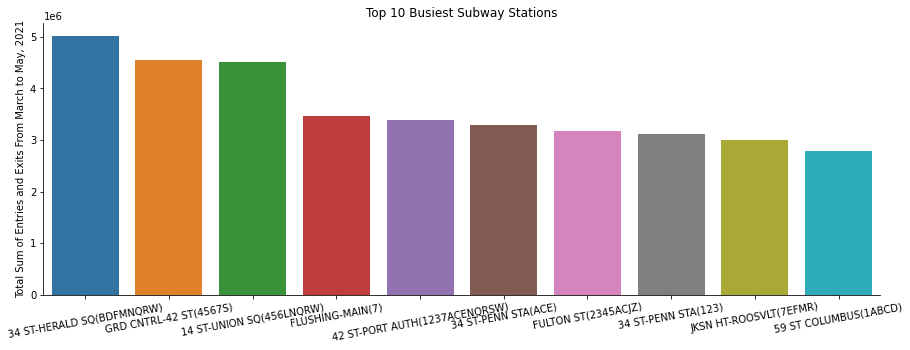

In [19]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='SUM_DAILY', data=top_10_station)
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Total Sum of Entries and Exits From March to May, 2021", fontsize = '10')
sns.despine()
plt.savefig("top10_sum_daily_visit_staition.png", dpi = 200);

In [20]:
#Station avg
station_daily_avg = (station_daily.groupby(["STATION"], as_index=False)
                                  .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                                  .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
top10_avg_staition = station_daily_avg.sort_values("AVG_DAILY", ascending=False).head(10)
top10_avg_staition

,STATION,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
85,34 ST-HERALD SQ(BDFMNQRW),54514.217391,22948.554348,31565.663043
302,GRD CNTRL-42 ST(4567S),49418.000000,20539.489130,28878.510870
26,14 ST-UNION SQ(456LNQRW),49110.510870,20181.728261,28928.782609
280,FLUSHING-MAIN(7),37760.804348,18514.913043,19245.891304
97,42 ST-PORT AUTH(1237ACENQRSW),36897.119565,16449.869565,20447.250000
88,34 ST-PENN STA(ACE),35777.000000,15115.434783,20661.565217
293,FULTON ST(2345ACJZ),34482.608696,15128.380435,19354.228261
87,34 ST-PENN STA(123),33950.489130,14542.130435,19408.358696
329,JKSN HT-ROOSVLT(7EFMR),32641.206522,17400.108696,15241.097826
116,59 ST COLUMBUS(1ABCD),30329.271739,14090.391304,16238.880435


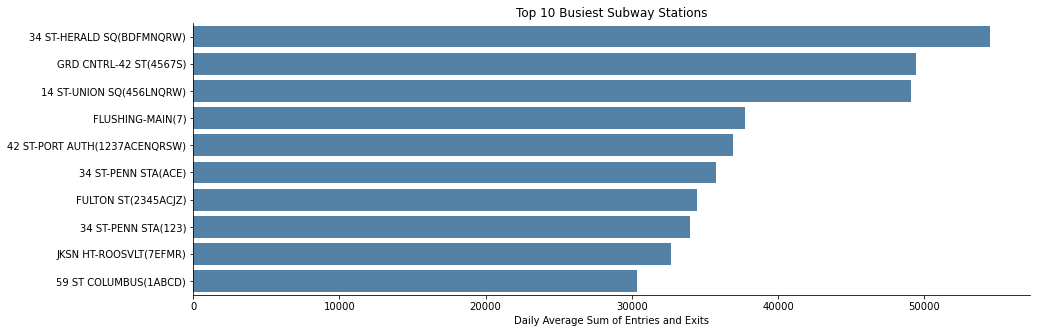

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x='AVG_DAILY', y='STATION', data=top10_avg_staition, color='steelblue')
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10')
plt.yticks(fontsize = '10')
plt.ylabel("")
plt.xlabel("Daily Average Sum of Entries and Exits", fontsize = '10')
sns.despine()
plt.savefig("images/top10_avg_daily_visit_staition.png", dpi = 400, facecolor = "w", bbox_inches="tight");

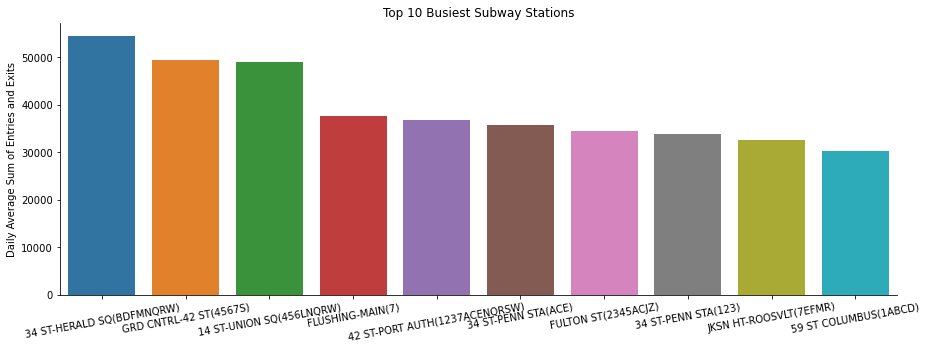

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='AVG_DAILY', data=top10_avg_staition)
plt.title("Top 10 Busiest Subway Stations")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Daily Average Sum of Entries and Exits", fontsize = '10')
sns.despine()
plt.savefig("top10_avg_daily_visit_staition_vertical.png", dpi = 200);

In [23]:
#weekday daily level
day_daily_sum = (daily.groupby(["DAY"], as_index=False)
                  .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
day_daily_sum

,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,43380826,21284345,22096481
1,1,43642200,21461126,22181074
2,2,43996700,21618621,22378079
3,3,43876746,21527535,22349211
4,4,44328977,21622311,22706666
5,5,29481694,13716089,15765605
6,6,21738153,9978823,11759330


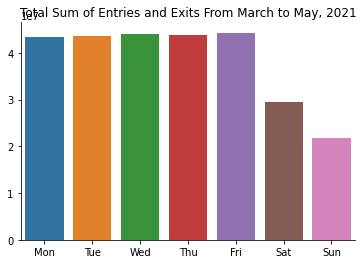

In [24]:
sns.barplot(x='DAY', y='SUM_DAILY', data=day_daily_sum)
plt.title("Total Sum of Entries and Exits From March to May, 2021")
plt.xticks(range(7), 
           ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], 
           fontsize = '10', rotation = 0)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.savefig("total_visit_day.png", dpi = 200);

In [25]:
#sum_by_date level
sum_by_date = (daily.groupby(["DATE", "DAY"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
sum_by_date

,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,2021-03-01,0,2837508,1393506,1444002
1,2021-03-02,1,3092470,1531328,1561142
2,2021-03-03,2,3244876,1605534,1639342
3,2021-03-04,3,3193006,1571550,1621456
4,2021-03-05,4,3221050,1581561,1639489
...,...,...,...,...,...
87,2021-05-27,3,3820790,1856052,1964738
88,2021-05-28,4,3664554,1769557,1894997
89,2021-05-29,5,2175792,1004847,1170945
90,2021-05-30,6,1686167,763204,922963


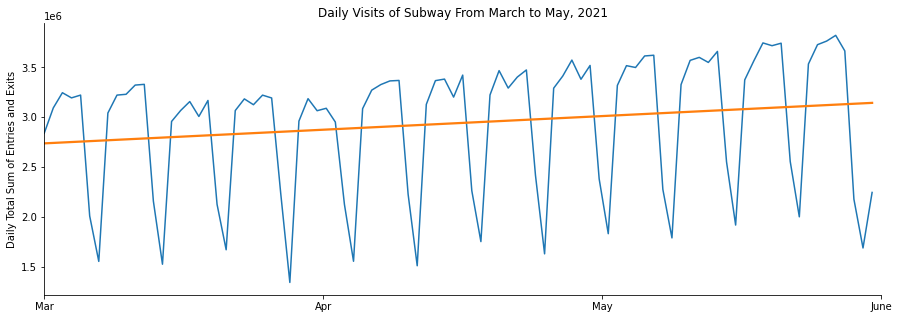

In [26]:
plt.figure(figsize=(15,5))
sns.lineplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY") 
sns.regplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY", ci=None, marker="")
plt.xticks(np.linspace(0,92,4), ['Mar', 'Apr', 'May', 'June'], fontsize = '10')
plt.title("Daily Visits of Subway From March to May, 2021")
plt.xlabel("")
plt.ylabel("Daily Total Sum of Entries and Exits")
sns.despine()
plt.savefig("images/total_visit_by_date.png", dpi = 400, facecolor = "w", bbox_inches="tight");


In [27]:
#avg day visits
day_avg = (sum_by_date.groupby(["DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                      .round()
                      .astype(int)
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
day_avg

,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,3098630,1520310,1578320
1,1,3357092,1650856,1706236
2,2,3384362,1662971,1721391
3,3,3375134,1655964,1719170
4,4,3409921,1663255,1746667
5,5,2267823,1055084,1212739
6,6,1672166,767602,904564


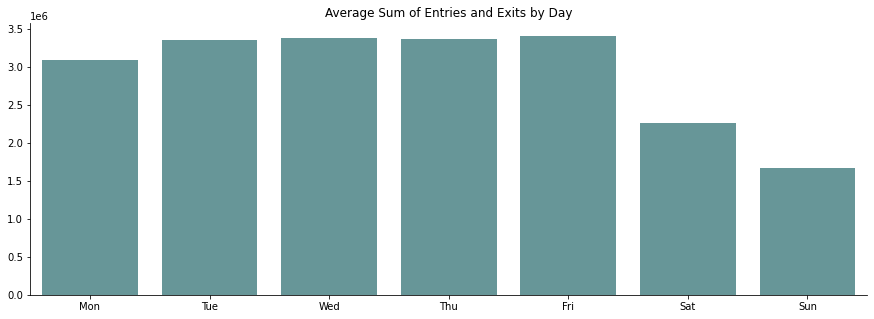

In [28]:
plt.figure(figsize=(15,5))
#sns.lineplot(x='DAY', y='AVG_DAILY', data=day_avg)
sns.barplot(x='DAY', y='AVG_DAILY', data=day_avg, color="cadetblue")
plt.title("Average Sum of Entries and Exits by Day")
plt.xticks(range(7), 
           ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], 
           fontsize = '10', rotation = 0)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("", fontsize = '10')
sns.despine()
plt.savefig("images/avg_daily_visit_day.png", dpi = 400, facecolor='w', bbox_inches="tight");

# 3. Busiest Control Area and Hour

In [29]:
time_df = df.drop(["DESC","ENTRIES","EXITS","PRE_ENTRIES","PRE_EXITS","PRE_TIME"], axis = 1)
#https://www.learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc
#b = [0,4,8,11,13,15,17,19,21,24]
#l = ['Late Night', 'Early Morning','Morning','Noon','Early Afternoon','Afternoon','Early Evening','Evening','Night']
#data is every 4 hours
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']
time_df["PERIOD"] = pd.cut(time_df["DATE_TIME"].dt.hour, bins=b, labels=l, include_lowest=True).astype(str)
#need to change "category" type to "str" for faster groupby

In [30]:
time_df.head(10)

,CA,SCP,STATION,LINENAME,DATE,TIME,DATE_TIME,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,LINENAME_FIX,PERIOD
0,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,07:00:00,2021-03-01 07:00:00,0,2,24,26,456NQRW,Early Morning
1,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,11:00:00,2021-03-01 11:00:00,0,52,116,168,456NQRW,Morning
2,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,15:00:00,2021-03-01 15:00:00,0,102,49,151,456NQRW,Afternoon
3,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,19:00:00,2021-03-01 19:00:00,0,278,45,323,456NQRW,Evening
4,A002,02-00-00,59 ST(456NQRW),NQR456W,03/01/2021,23:00:00,2021-03-01 23:00:00,0,106,16,122,456NQRW,Night
5,A002,02-00-00,59 ST(456NQRW),NQR456W,03/02/2021,03:00:00,2021-03-02 03:00:00,1,9,1,10,456NQRW,Late Night
6,A002,02-00-00,59 ST(456NQRW),NQR456W,03/02/2021,07:00:00,2021-03-02 07:00:00,1,10,26,36,456NQRW,Early Morning
7,A002,02-00-00,59 ST(456NQRW),NQR456W,03/02/2021,11:00:00,2021-03-02 11:00:00,1,50,129,179,456NQRW,Morning
8,A002,02-00-00,59 ST(456NQRW),NQR456W,03/02/2021,15:00:00,2021-03-02 15:00:00,1,103,38,141,456NQRW,Afternoon
9,A002,02-00-00,59 ST(456NQRW),NQR456W,03/02/2021,19:00:00,2021-03-02 19:00:00,1,249,33,282,456NQRW,Evening


In [31]:
time_df.dtypes

CA                        object
SCP                       object
STATION                   object
LINENAME                  object
DATE                      object
TIME                      object
DATE_TIME         datetime64[ns]
DAY                        int64
PERIOD_ENTRIES             int64
PERIOD_EXITS               int64
PERIOD_VISITS              int64
LINENAME_FIX              object
PERIOD                    object
dtype: object

In [32]:
#CA, DAY, PERIOD level by DATE
ca_df = (time_df.groupby(["CA","STATION","DATE","PERIOD", "DAY"], as_index=False)
                [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].sum())
ca_df

,CA,STATION,DATE,PERIOD,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
0,A002,59 ST(456NQRW),03/01/2021,Afternoon,0,701,616,1317
1,A002,59 ST(456NQRW),03/01/2021,Early Morning,0,53,389,442
2,A002,59 ST(456NQRW),03/01/2021,Evening,0,2151,520,2671
3,A002,59 ST(456NQRW),03/01/2021,Morning,0,451,1681,2132
4,A002,59 ST(456NQRW),03/01/2021,Night,0,743,189,932
...,...,...,...,...,...,...,...,...
378104,TRAM2,RIT-ROOSEVELT(R),05/31/2021,Early Morning,0,2,4,6
378105,TRAM2,RIT-ROOSEVELT(R),05/31/2021,Evening,0,1084,9,1093
378106,TRAM2,RIT-ROOSEVELT(R),05/31/2021,Late Night,0,155,8,163
378107,TRAM2,RIT-ROOSEVELT(R),05/31/2021,Morning,0,102,0,102


In [33]:
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
period_df = (ca_df.groupby(["PERIOD", "DAY"], as_index=False)
                [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].sum())
period_df.PERIOD=period_df.PERIOD.map(period_dict)
period_df.sort_values("PERIOD_VISITS", ascending=False)

,PERIOD,DAY,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
18,4,4,6770394,7224462,13994856
17,4,3,6678590,6944568,13623158
16,4,2,6689489,6909375,13598864
15,4,1,6689683,6895604,13585287
14,4,0,6635646,6879602,13515248
30,2,2,5277604,5624545,10902149
29,2,1,5243404,5609970,10853374
31,2,3,5236296,5577753,10814049
28,2,0,5218448,5573866,10792314
4,3,4,5184668,5413551,10598219


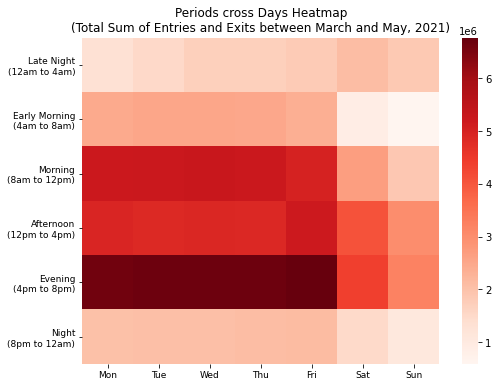

In [34]:
day_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
period_list = (['Late Night\n(12am to 4am)', 
                'Early Morning\n(4am to 8am)',
                'Morning\n(8am to 12pm)',
                'Afternoon\n(12pm to 4pm)',
                'Evening\n(4pm to 8pm)',
                'Night\n(8pm to 12am)'])
plt.figure(figsize=(8,6))
sns.heatmap(period_df.pivot("PERIOD", "DAY", "PERIOD_ENTRIES"), cmap="Reds")
plt.xticks(np.arange(0.5,7.5,1), day_list, fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,6.5,1), period_list, fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("Periods cross Days Heatmap\n(Total Sum of Entries and Exits between March and May, 2021)")
plt.savefig("images/day_period_heatmap.png", dpi = 500, facecolor ="w", bbox_inches="tight");

In [35]:
#AVG CA by day and hour
ca_when_df = (ca_df.groupby(["CA","STATION","DAY","PERIOD"], as_index=False)
              [["PERIOD_ENTRIES", "PERIOD_EXITS", "PERIOD_VISITS"]].mean())
ca_when_df["RATIO"] = ca_when_df["PERIOD_VISITS"] / ca_when_df["PERIOD_VISITS"].max()
ca_when_df["STA_CA"] = ca_when_df["CA"] + "|" + ca_when_df["STATION"] #+ "("+ ca_when_df["RATIO"].round(2).astype(str) + ")"
ca_when_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
0,A002,59 ST(456NQRW),0,Afternoon,1039.000000,633.714286,1672.714286,0.151705,A002|59 ST(456NQRW)
1,A002,59 ST(456NQRW),0,Early Morning,154.357143,735.571429,889.928571,0.080711,A002|59 ST(456NQRW)
2,A002,59 ST(456NQRW),0,Evening,2000.500000,504.785714,2505.285714,0.227215,A002|59 ST(456NQRW)
3,A002,59 ST(456NQRW),0,Late Night,359.153846,163.307692,522.461538,0.047384,A002|59 ST(456NQRW)
4,A002,59 ST(456NQRW),0,Morning,468.428571,1400.500000,1868.928571,0.169501,A002|59 ST(456NQRW)
...,...,...,...,...,...,...,...,...,...
31488,TRAM2,RIT-ROOSEVELT(R),6,Early Morning,11.461538,2.923077,14.384615,0.001305,TRAM2|RIT-ROOSEVELT(R)
31489,TRAM2,RIT-ROOSEVELT(R),6,Evening,751.076923,9.076923,760.153846,0.068941,TRAM2|RIT-ROOSEVELT(R)
31490,TRAM2,RIT-ROOSEVELT(R),6,Late Night,171.769231,8.153846,179.923077,0.016318,TRAM2|RIT-ROOSEVELT(R)
31491,TRAM2,RIT-ROOSEVELT(R),6,Morning,89.538462,4.846154,94.384615,0.008560,TRAM2|RIT-ROOSEVELT(R)


In [36]:
ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(20)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
29419,R533,FLUSHING-MAIN(7),4,Evening,4758.461538,6267.615385,11026.076923,1.000000,R533|FLUSHING-MAIN(7)
29401,R533,FLUSHING-MAIN(7),1,Evening,4636.076923,6202.461538,10838.538462,0.982991,R533|FLUSHING-MAIN(7)
29407,R533,FLUSHING-MAIN(7),2,Evening,4544.000000,6151.692308,10695.692308,0.970036,R533|FLUSHING-MAIN(7)
29413,R533,FLUSHING-MAIN(7),3,Evening,4454.846154,6108.692308,10563.538462,0.958050,R533|FLUSHING-MAIN(7)
29395,R533,FLUSHING-MAIN(7),0,Evening,4448.642857,5970.285714,10418.928571,0.944935,R533|FLUSHING-MAIN(7)
19321,PTH22,PATH NEW WTC(1),1,Evening,7187.307692,2152.769231,9340.076923,0.847090,PTH22|PATH NEW WTC(1)
19327,PTH22,PATH NEW WTC(1),2,Evening,7148.153846,2111.076923,9259.230769,0.839757,PTH22|PATH NEW WTC(1)
19339,PTH22,PATH NEW WTC(1),4,Evening,6374.538462,2506.461538,8881.000000,0.805454,PTH22|PATH NEW WTC(1)
14054,N324,JKSN HT-ROOSVLT(7EFMR),4,Evening,3286.692308,5387.384615,8674.076923,0.786688,N324|JKSN HT-ROOSVLT(7EFMR)
14048,N324,JKSN HT-ROOSVLT(7EFMR),3,Evening,3120.538462,5527.000000,8647.538462,0.784281,N324|JKSN HT-ROOSVLT(7EFMR)


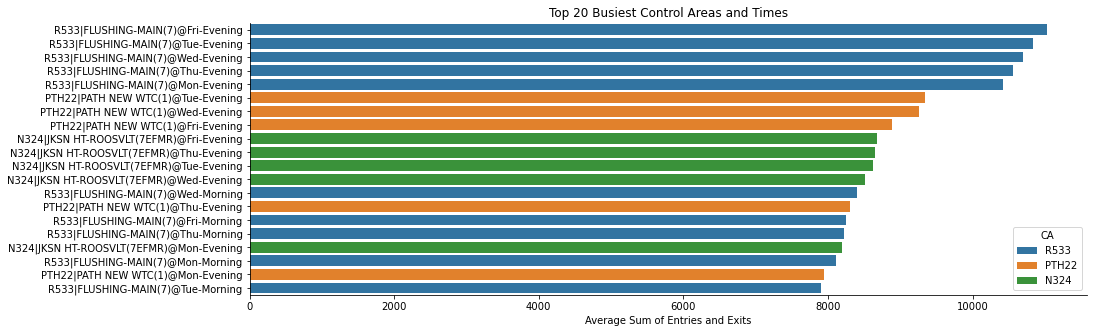

In [37]:
top_avg_ca = ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(20)
top_avg_ca.DAY = top_avg_ca.DAY.map({0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"})
top_avg_ca.STA_CA = top_avg_ca["STA_CA"] + "@" + top_avg_ca["DAY"] + "-" + top_avg_ca["PERIOD"]

plt.figure(figsize=(15,5))
sns.barplot(x='PERIOD_VISITS', y='STA_CA', data=top_avg_ca, hue="CA", dodge=False)
plt.title("Top 20 Busiest Control Areas and Times")
plt.xticks(fontsize = '10')
plt.yticks(fontsize = '10')
plt.ylabel("")
plt.xlabel("Average Sum of Entries and Exits", fontsize = '10')
sns.despine();
plt.savefig("images/top20_ca_period.png", dpi = 400, facecolor = "w", bbox_inches="tight");

(array([35.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0., 10.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

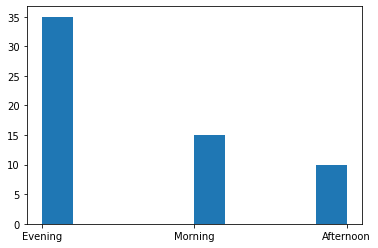

In [38]:
plt.hist(data=ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(60), x="PERIOD")

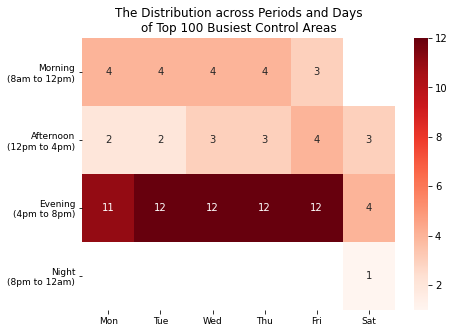

In [39]:
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
test_df = ca_when_df.sort_values("PERIOD_VISITS", ascending=False).head(100).groupby(["PERIOD", "DAY"], as_index=False).RATIO.count()
test_df.PERIOD=test_df.PERIOD.map(period_dict)
plt.figure(figsize=(7,5))
sns.heatmap(test_df.pivot("PERIOD", "DAY"), cmap="Reds", annot=True)
plt.xticks(np.arange(0.5,6.5,1), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,4.5,1), (['Morning\n(8am to 12pm)',
                                   'Afternoon\n(12pm to 4pm)',
                                   'Evening\n(4pm to 8pm)','Night\n(8pm to 12am)']), fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("The Distribution across Periods and Days\nof Top 100 Busiest Control Areas")
plt.savefig("images/top100_ca_period_heatmap.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [40]:
ca_when_df[ca_when_df["STATION"] == "34 ST-HERALD SQ(BDFMNQRW)"].sort_values("PERIOD_VISITS", ascending=False).head(10)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
15986,N506,34 ST-HERALD SQ(BDFMNQRW),4,Evening,3750.692308,4119.230769,7869.923077,0.713756,N506|34 ST-HERALD SQ(BDFMNQRW)
15980,N506,34 ST-HERALD SQ(BDFMNQRW),3,Evening,3497.153846,3429.615385,6926.769231,0.628217,N506|34 ST-HERALD SQ(BDFMNQRW)
15968,N506,34 ST-HERALD SQ(BDFMNQRW),1,Evening,3534.461538,3252.076923,6786.538462,0.615499,N506|34 ST-HERALD SQ(BDFMNQRW)
15974,N506,34 ST-HERALD SQ(BDFMNQRW),2,Evening,3458.769231,3323.769231,6782.538462,0.615136,N506|34 ST-HERALD SQ(BDFMNQRW)
15984,N506,34 ST-HERALD SQ(BDFMNQRW),4,Afternoon,2637.615385,3777.615385,6415.230769,0.581824,N506|34 ST-HERALD SQ(BDFMNQRW)
15962,N506,34 ST-HERALD SQ(BDFMNQRW),0,Evening,3365.785714,3036.500000,6402.285714,0.580649,N506|34 ST-HERALD SQ(BDFMNQRW)
15992,N506,34 ST-HERALD SQ(BDFMNQRW),5,Evening,3035.230769,3339.692308,6374.923077,0.578168,N506|34 ST-HERALD SQ(BDFMNQRW)
15990,N506,34 ST-HERALD SQ(BDFMNQRW),5,Afternoon,2448.153846,3856.769231,6304.923077,0.571819,N506|34 ST-HERALD SQ(BDFMNQRW)
488,A025,34 ST-HERALD SQ(BDFMNQRW),4,Evening,3109.076923,3172.846154,6281.923077,0.569733,A025|34 ST-HERALD SQ(BDFMNQRW)
482,A025,34 ST-HERALD SQ(BDFMNQRW),3,Evening,3219.000000,2796.461538,6015.461538,0.545567,A025|34 ST-HERALD SQ(BDFMNQRW)


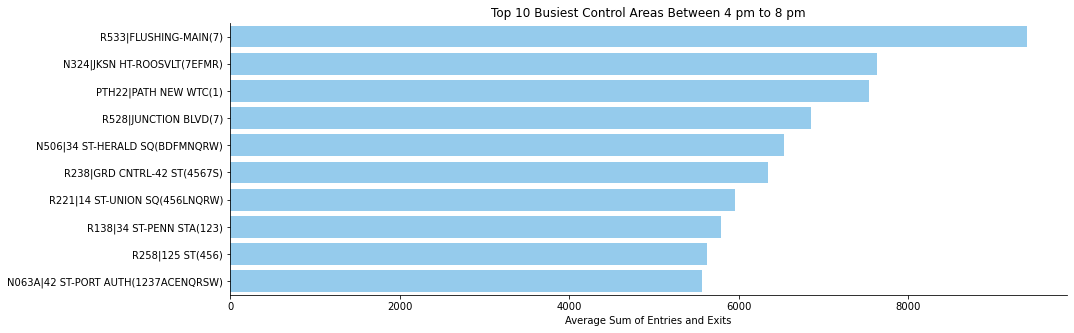

In [41]:
top10_avg_eveing_ca = (ca_when_df[ca_when_df["PERIOD"] == "Evening"]
                       .groupby(["STA_CA"], as_index=False)
                       .PERIOD_VISITS.mean())
top10_avg_eveing_ca = top10_avg_eveing_ca.sort_values("PERIOD_VISITS", ascending=False).head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='PERIOD_VISITS', y='STA_CA', data=top10_avg_eveing_ca, color='lightskyblue')
plt.title("Top 10 Busiest Control Areas Between 4 pm to 8 pm")
plt.xticks(fontsize = '10')
plt.yticks(fontsize = '10')
plt.ylabel("")
plt.xlabel("Average Sum of Entries and Exits", fontsize = '10')
sns.despine();
plt.savefig("images/top10_ca_evening.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [42]:
ca_df[ca_df.STATION == "FLUSHING-MAIN"].groupby("CA").PERIOD_VISITS.mean()

Series([], Name: PERIOD_VISITS, dtype: float64)

In [43]:
for day in range(7):
    print(ca_when_df[ca_when_df.DAY == day].sort_values("PERIOD_VISITS", ascending=False).head(10))
    

          CA                    STATION  DAY     PERIOD  PERIOD_ENTRIES  \
29395   R533           FLUSHING-MAIN(7)    0    Evening     4448.642857   
14030   N324     JKSN HT-ROOSVLT(7EFMR)    0    Evening     3047.642857   
29397   R533           FLUSHING-MAIN(7)    0    Morning     4966.357143   
19315  PTH22            PATH NEW WTC(1)    0    Evening     6014.357143   
29185   R528           JUNCTION BLVD(7)    0    Evening     1694.642857   
29393   R533           FLUSHING-MAIN(7)    0  Afternoon     3678.714286   
19317  PTH22            PATH NEW WTC(1)    0    Morning     1363.571429   
24103   R238     GRD CNTRL-42 ST(4567S)    0    Evening     2855.214286   
14032   N324     JKSN HT-ROOSVLT(7EFMR)    0    Morning     4694.142857   
15962   N506  34 ST-HERALD SQ(BDFMNQRW)    0    Evening     3365.785714   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                          STA_CA  
29395   5970.285714   10418.928571  0.944935           R533|FLUSHING-MAIN(7)  
14030   5147.571

         CA                    STATION  DAY      PERIOD  PERIOD_ENTRIES  \
29429  R533           FLUSHING-MAIN(7)    6   Afternoon     2727.230769   
29431  R533           FLUSHING-MAIN(7)    6     Evening     2613.461538   
14064  N324     JKSN HT-ROOSVLT(7EFMR)    6   Afternoon     2537.769231   
14067  N324     JKSN HT-ROOSVLT(7EFMR)    6  Late Night     1478.461538   
15996  N506  34 ST-HERALD SQ(BDFMNQRW)    6   Afternoon     1769.076923   
15998  N506  34 ST-HERALD SQ(BDFMNQRW)    6     Evening     2354.230769   
14066  N324     JKSN HT-ROOSVLT(7EFMR)    6     Evening     1794.153846   
29221  R528           JUNCTION BLVD(7)    6     Evening     1280.307692   
29219  R528           JUNCTION BLVD(7)    6   Afternoon     2037.538462   
29433  R533           FLUSHING-MAIN(7)    6     Morning     2314.846154   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                          STA_CA  
29429   2696.769231    5424.000000  0.491925           R533|FLUSHING-MAIN(7)  
29431   2667.692

In [44]:
ca_when_df[(ca_when_df.DAY == 0) & (ca_when_df.PERIOD == "Morning")].sort_values("PERIOD_VISITS", ascending=False).head(10)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
29397,R533,FLUSHING-MAIN(7),0,Morning,4966.357143,3139.142857,8105.500000,0.735121,R533|FLUSHING-MAIN(7)
19317,PTH22,PATH NEW WTC(1),0,Morning,1363.571429,5525.714286,6889.285714,0.624817,PTH22|PATH NEW WTC(1)
14032,N324,JKSN HT-ROOSVLT(7EFMR),0,Morning,4694.142857,1904.357143,6598.500000,0.598445,N324|JKSN HT-ROOSVLT(7EFMR)
24105,R238,GRD CNTRL-42 ST(4567S),0,Morning,1874.785714,4336.428571,6211.214286,0.563320,R238|GRD CNTRL-42 ST(4567S)
20913,R138,34 ST-PENN STA(123),0,Morning,3596.785714,1872.000000,5468.785714,0.495987,R138|34 ST-PENN STA(123)
25029,R258,125 ST(456),0,Morning,1952.000000,3074.142857,5026.142857,0.455841,R258|125 ST(456)
24693,R249,86 ST(456),0,Morning,529.214286,4233.928571,4763.142857,0.431989,R249|86 ST(456)
15712,N501,47-50 STS ROCK(BDFM),0,Morning,370.785714,4215.714286,4586.500000,0.415968,N501|47-50 STS ROCK(BDFM)
18645,PTH03,JOURNAL SQUARE(1),0,Morning,3742.642857,736.214286,4478.857143,0.406206,PTH03|JOURNAL SQUARE(1)
29187,R528,JUNCTION BLVD(7),0,Morning,3141.428571,1273.428571,4414.857143,0.400401,R528|JUNCTION BLVD(7)


In [45]:
#loop to get top 10 of different periods of different days 
period_day_df = ca_when_df[0:0]
#.drop(['CA', 'STATION', 'PERIOD_ENTRIES', 'PERIOD_EXITS'], axis=1)
for day in range(7):
    for period in ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']:
        period_day_df = period_day_df.append(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)]
                                            .sort_values("PERIOD_VISITS", ascending=False)
                                            .head(1))
period_day_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
14031,N324,JKSN HT-ROOSVLT(7EFMR),0,Late Night,1079.692308,2307.230769,3386.923077,0.307174,N324|JKSN HT-ROOSVLT(7EFMR)
29394,R533,FLUSHING-MAIN(7),0,Early Morning,3531.142857,1487.142857,5018.285714,0.455129,R533|FLUSHING-MAIN(7)
29397,R533,FLUSHING-MAIN(7),0,Morning,4966.357143,3139.142857,8105.500000,0.735121,R533|FLUSHING-MAIN(7)
29393,R533,FLUSHING-MAIN(7),0,Afternoon,3678.714286,3522.928571,7201.642857,0.653146,R533|FLUSHING-MAIN(7)
29395,R533,FLUSHING-MAIN(7),0,Evening,4448.642857,5970.285714,10418.928571,0.944935,R533|FLUSHING-MAIN(7)
23434,R221,14 ST-UNION SQ(456LNQRW),0,Night,2359.416667,2315.750000,4675.166667,0.424010,R221|14 ST-UNION SQ(456LNQRW)
29402,R533,FLUSHING-MAIN(7),1,Late Night,1426.615385,2235.384615,3662.000000,0.332122,R533|FLUSHING-MAIN(7)
29400,R533,FLUSHING-MAIN(7),1,Early Morning,4094.615385,1701.384615,5796.000000,0.525663,R533|FLUSHING-MAIN(7)
29403,R533,FLUSHING-MAIN(7),1,Morning,4868.538462,3034.000000,7902.538462,0.716714,R533|FLUSHING-MAIN(7)
29399,R533,FLUSHING-MAIN(7),1,Afternoon,3689.846154,3498.692308,7188.538462,0.651958,R533|FLUSHING-MAIN(7)


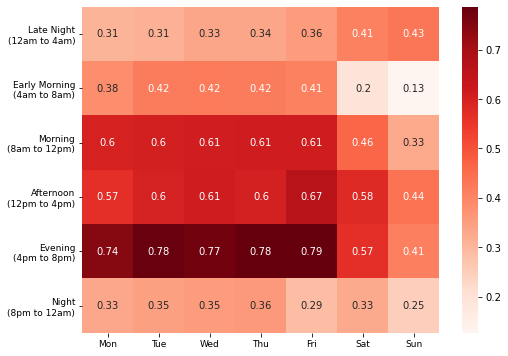

In [46]:
n324_df = ca_when_df[ca_when_df["CA"] == "N324"].sort_values("RATIO", ascending=False)
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
n324_df.PERIOD=n324_df.PERIOD.map(period_dict)
day_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
period_list = (['Late Night\n(12am to 4am)', 
                'Early Morning\n(4am to 8am)',
                'Morning\n(8am to 12pm)',
                'Afternoon\n(12pm to 4pm)',
                'Evening\n(4pm to 8pm)',
                'Night\n(8pm to 12am)'])
plt.figure(figsize=(8,6))
sns.heatmap(n324_df.pivot("PERIOD", "DAY", "RATIO"), cmap="Reds", annot=True)
plt.xticks(np.arange(0.5,7.5,1), day_list, fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,6.5,1), period_list, fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("");

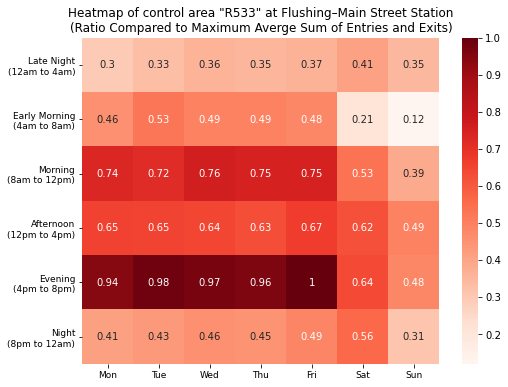

In [47]:
r533_df = ca_when_df[ca_when_df["CA"] == "R533"].sort_values("RATIO", ascending=False)
period_dict = {'Late Night':0, 'Early Morning':1, 'Morning':2, 'Afternoon':3,'Evening':4,'Night':5}
r533_df.PERIOD=r533_df.PERIOD.map(period_dict)
day_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
period_list = (['Late Night\n(12am to 4am)', 
                'Early Morning\n(4am to 8am)',
                'Morning\n(8am to 12pm)',
                'Afternoon\n(12pm to 4pm)',
                'Evening\n(4pm to 8pm)',
                'Night\n(8pm to 12am)'])
plt.figure(figsize=(8,6))
sns.heatmap(r533_df.pivot("PERIOD", "DAY", "RATIO"), cmap="Reds", annot=True)
plt.xticks(np.arange(0.5,7.5,1), day_list, fontsize = '9', rotation = 0)
plt.yticks(np.arange(0.5,6.5,1), period_list, fontsize = '9', rotation = 0)
plt.xlabel("")
plt.ylabel("")
plt.title("Heatmap of control area \"R533\" at Flushing–Main Street Station\n(Ratio Compared to Maximum Averge Sum of Entries and Exits)")
plt.savefig("images/r533_heatmap.png", dpi = 500, facecolor ="w", bbox_inches="tight");

In [48]:
r533_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
29419,R533,FLUSHING-MAIN(7),4,4,4758.461538,6267.615385,11026.076923,1.000000,R533|FLUSHING-MAIN(7)
29401,R533,FLUSHING-MAIN(7),1,4,4636.076923,6202.461538,10838.538462,0.982991,R533|FLUSHING-MAIN(7)
29407,R533,FLUSHING-MAIN(7),2,4,4544.000000,6151.692308,10695.692308,0.970036,R533|FLUSHING-MAIN(7)
29413,R533,FLUSHING-MAIN(7),3,4,4454.846154,6108.692308,10563.538462,0.958050,R533|FLUSHING-MAIN(7)
29395,R533,FLUSHING-MAIN(7),0,4,4448.642857,5970.285714,10418.928571,0.944935,R533|FLUSHING-MAIN(7)
29409,R533,FLUSHING-MAIN(7),2,2,5237.538462,3168.923077,8406.461538,0.762416,R533|FLUSHING-MAIN(7)
29421,R533,FLUSHING-MAIN(7),4,2,5116.307692,3139.923077,8256.230769,0.748791,R533|FLUSHING-MAIN(7)
29415,R533,FLUSHING-MAIN(7),3,2,5142.846154,3083.692308,8226.538462,0.746098,R533|FLUSHING-MAIN(7)
29397,R533,FLUSHING-MAIN(7),0,2,4966.357143,3139.142857,8105.500000,0.735121,R533|FLUSHING-MAIN(7)
29403,R533,FLUSHING-MAIN(7),1,2,4868.538462,3034.000000,7902.538462,0.716714,R533|FLUSHING-MAIN(7)


In [49]:
n324_df

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
14054,N324,JKSN HT-ROOSVLT(7EFMR),4,4,3286.692308,5387.384615,8674.076923,0.786688,N324|JKSN HT-ROOSVLT(7EFMR)
14048,N324,JKSN HT-ROOSVLT(7EFMR),3,4,3120.538462,5527.000000,8647.538462,0.784281,N324|JKSN HT-ROOSVLT(7EFMR)
14036,N324,JKSN HT-ROOSVLT(7EFMR),1,4,3147.307692,5475.923077,8623.230769,0.782076,N324|JKSN HT-ROOSVLT(7EFMR)
14042,N324,JKSN HT-ROOSVLT(7EFMR),2,4,3085.153846,5424.538462,8509.692308,0.771779,N324|JKSN HT-ROOSVLT(7EFMR)
14030,N324,JKSN HT-ROOSVLT(7EFMR),0,4,3047.642857,5147.571429,8195.214286,0.743257,N324|JKSN HT-ROOSVLT(7EFMR)
14052,N324,JKSN HT-ROOSVLT(7EFMR),4,3,3711.692308,3624.692308,7336.384615,0.665367,N324|JKSN HT-ROOSVLT(7EFMR)
14040,N324,JKSN HT-ROOSVLT(7EFMR),2,3,3360.846154,3396.000000,6756.846154,0.612806,N324|JKSN HT-ROOSVLT(7EFMR)
14056,N324,JKSN HT-ROOSVLT(7EFMR),4,2,4885.923077,1869.230769,6755.153846,0.612653,N324|JKSN HT-ROOSVLT(7EFMR)
14050,N324,JKSN HT-ROOSVLT(7EFMR),3,2,4874.000000,1875.769231,6749.769231,0.612164,N324|JKSN HT-ROOSVLT(7EFMR)
14044,N324,JKSN HT-ROOSVLT(7EFMR),2,2,4819.538462,1906.846154,6726.384615,0.610043,N324|JKSN HT-ROOSVLT(7EFMR)


In [50]:
period_day_df = ca_when_df[0:0]
#.drop(['CA', 'STATION', 'PERIOD_ENTRIES', 'PERIOD_EXITS'], axis=1)
for day in range(7):
    for period in ['Morning','Afternoon','Evening']:
        period_day_df = period_day_df.append(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)]
                                            .sort_values("PERIOD_VISITS", ascending=False)
                                            .head(10))
period_day_df


,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA
29397,R533,FLUSHING-MAIN(7),0,Morning,4966.357143,3139.142857,8105.500000,0.735121,R533|FLUSHING-MAIN(7)
19317,PTH22,PATH NEW WTC(1),0,Morning,1363.571429,5525.714286,6889.285714,0.624817,PTH22|PATH NEW WTC(1)
14032,N324,JKSN HT-ROOSVLT(7EFMR),0,Morning,4694.142857,1904.357143,6598.500000,0.598445,N324|JKSN HT-ROOSVLT(7EFMR)
24105,R238,GRD CNTRL-42 ST(4567S),0,Morning,1874.785714,4336.428571,6211.214286,0.563320,R238|GRD CNTRL-42 ST(4567S)
20913,R138,34 ST-PENN STA(123),0,Morning,3596.785714,1872.000000,5468.785714,0.495987,R138|34 ST-PENN STA(123)
...,...,...,...,...,...,...,...,...,...
19351,PTH22,PATH NEW WTC(1),6,Evening,2088.000000,1545.461538,3633.461538,0.329533,PTH22|PATH NEW WTC(1)
9908,N083,W 4 ST-WASH SQ(ABCDEFM),6,Evening,1237.307692,2357.153846,3594.461538,0.325996,N083|W 4 ST-WASH SQ(ABCDEFM)
24139,R238,GRD CNTRL-42 ST(4567S),6,Evening,1613.000000,1914.846154,3527.846154,0.319955,R238|GRD CNTRL-42 ST(4567S)
25063,R258,125 ST(456),6,Evening,1359.692308,2101.692308,3461.384615,0.313927,R258|125 ST(456)


In [51]:
ca_when_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31493 entries, 0 to 31492
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CA              31493 non-null  object 
 1   STATION         31493 non-null  object 
 2   DAY             31493 non-null  int64  
 3   PERIOD          31493 non-null  object 
 4   PERIOD_ENTRIES  31493 non-null  float64
 5   PERIOD_EXITS    31493 non-null  float64
 6   PERIOD_VISITS   31493 non-null  float64
 7   RATIO           31493 non-null  float64
 8   STA_CA          31493 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.2+ MB


In [52]:
for day in range(7):
    for period in ['Morning','Afternoon','Evening', 'Night', 'Late Night']:
        print(ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)].sort_values("PERIOD_VISITS",ascending=False).head(10))

          CA                 STATION  DAY   PERIOD  PERIOD_ENTRIES  \
29397   R533        FLUSHING-MAIN(7)    0  Morning     4966.357143   
19317  PTH22         PATH NEW WTC(1)    0  Morning     1363.571429   
14032   N324  JKSN HT-ROOSVLT(7EFMR)    0  Morning     4694.142857   
24105   R238  GRD CNTRL-42 ST(4567S)    0  Morning     1874.785714   
20913   R138     34 ST-PENN STA(123)    0  Morning     3596.785714   
25029   R258             125 ST(456)    0  Morning     1952.000000   
24693   R249              86 ST(456)    0  Morning      529.214286   
15712   N501    47-50 STS ROCK(BDFM)    0  Morning      370.785714   
18645  PTH03       JOURNAL SQUARE(1)    0  Morning     3742.642857   
29187   R528        JUNCTION BLVD(7)    0  Morning     3141.428571   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                       STA_CA  
29397   3139.142857    8105.500000  0.735121        R533|FLUSHING-MAIN(7)  
19317   5525.714286    6889.285714  0.624817        PTH22|PATH NEW WTC(1)  
1

23437        R221|14 ST-UNION SQ(456LNQRW)  
          CA                   STATION  DAY PERIOD  PERIOD_ENTRIES  \
23440   R221  14 ST-UNION SQ(456LNQRW)    1  Night     2670.454545   
25036   R258               125 ST(456)    1  Night     2299.363636   
29404   R533          FLUSHING-MAIN(7)    1  Night     1822.000000   
21844   R169                96 ST(123)    1  Night     1926.545455   
9881    N083   W 4 ST-WASH SQ(ABCDEFM)    1  Night     1988.272727   
725     A034  14 ST-UNION SQ(456LNQRW)    1  Night     2203.363636   
14039   N324    JKSN HT-ROOSVLT(7EFMR)    1  Night     1300.000000   
28984   R523         61 ST WOODSIDE(7)    1  Night     1066.909091   
27892   R417            PARKCHESTER(6)    1  Night      711.363636   
19324  PTH22           PATH NEW WTC(1)    1  Night     2874.307692   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                         STA_CA  
23440   2618.272727    5288.727273  0.479656  R221|14 ST-UNION SQ(456LNQRW)  
25036   2670.636364    4970.

          CA                 STATION  DAY   PERIOD  PERIOD_ENTRIES  \
29415   R533        FLUSHING-MAIN(7)    3  Morning     5142.846154   
19335  PTH22         PATH NEW WTC(1)    3  Morning     1412.923077   
14050   N324  JKSN HT-ROOSVLT(7EFMR)    3  Morning     4874.000000   
24123   R238  GRD CNTRL-42 ST(4567S)    3  Morning     1940.692308   
20931   R138     34 ST-PENN STA(123)    3  Morning     3866.769231   
24711   R249              86 ST(456)    3  Morning      568.230769   
25047   R258             125 ST(456)    3  Morning     2091.692308   
15730   N501    47-50 STS ROCK(BDFM)    3  Morning      422.000000   
29205   R528        JUNCTION BLVD(7)    3  Morning     3485.000000   
18663  PTH03       JOURNAL SQUARE(1)    3  Morning     3852.230769   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                       STA_CA  
29415   3083.692308    8226.538462  0.746098        R533|FLUSHING-MAIN(7)  
19335   5711.615385    7124.538462  0.646154        PTH22|PATH NEW WTC(1)  
1

24719   3217.846154    4177.076923  0.378836                 R249|86 ST(456)  
          CA                    STATION  DAY   PERIOD  PERIOD_ENTRIES  \
29425   R533           FLUSHING-MAIN(7)    5  Evening     3466.615385   
15992   N506  34 ST-HERALD SQ(BDFMNQRW)    5  Evening     3035.230769   
14060   N324     JKSN HT-ROOSVLT(7EFMR)    5  Evening     2462.750000   
29215   R528           JUNCTION BLVD(7)    5  Evening     1637.692308   
23461   R221   14 ST-UNION SQ(456LNQRW)    5  Evening     2189.000000   
19345  PTH22            PATH NEW WTC(1)    5  Evening     3025.923077   
746     A034   14 ST-UNION SQ(456LNQRW)    5  Evening     2096.692308   
9902    N083    W 4 ST-WASH SQ(ABCDEFM)    5  Evening     1671.846154   
5450    H009              BEDFORD AV(L)    5  Evening     2208.307692   
24133   R238     GRD CNTRL-42 ST(4567S)    5  Evening     1926.461538   

       PERIOD_EXITS  PERIOD_VISITS     RATIO                          STA_CA  
29425   3554.000000    7020.615385  0.

In [53]:
md_table = []

for period in ['Morning','Afternoon','Evening', 'Night']:
    md_table.append(period)
    for day in range(7):
        temp_df = ca_when_df[(ca_when_df.DAY == day) & (ca_when_df.PERIOD == period)].sort_values("PERIOD_VISITS", ascending=False).head(10)
        temp_df.index=[''] * len(temp_df)
#str(day) + "/" + period + ":" + 
        md_table.append(("<br />").join(list(temp_df.STA_CA + "(" + temp_df.RATIO.round(2).astype(str) + ")")))
#print(period + " uses:" + "|".join(md_table))
    print("|".join(md_table))
    md_table=[]

Morning|R533|FLUSHING-MAIN(7)(0.74)<br />PTH22|PATH NEW WTC(1)(0.62)<br />N324|JKSN HT-ROOSVLT(7EFMR)(0.6)<br />R238|GRD CNTRL-42 ST(4567S)(0.56)<br />R138|34 ST-PENN STA(123)(0.5)<br />R258|125 ST(456)(0.46)<br />R249|86 ST(456)(0.43)<br />N501|47-50 STS ROCK(BDFM)(0.42)<br />PTH03|JOURNAL SQUARE(1)(0.41)<br />R528|JUNCTION BLVD(7)(0.4)|R533|FLUSHING-MAIN(7)(0.72)<br />PTH22|PATH NEW WTC(1)(0.69)<br />N324|JKSN HT-ROOSVLT(7EFMR)(0.6)<br />R238|GRD CNTRL-42 ST(4567S)(0.6)<br />R138|34 ST-PENN STA(123)(0.54)<br />R258|125 ST(456)(0.49)<br />N501|47-50 STS ROCK(BDFM)(0.46)<br />R249|86 ST(456)(0.45)<br />R528|JUNCTION BLVD(7)(0.43)<br />PTH03|JOURNAL SQUARE(1)(0.42)|R533|FLUSHING-MAIN(7)(0.76)<br />PTH22|PATH NEW WTC(1)(0.65)<br />N324|JKSN HT-ROOSVLT(7EFMR)(0.61)<br />R238|GRD CNTRL-42 ST(4567S)(0.6)<br />R138|34 ST-PENN STA(123)(0.53)<br />R258|125 ST(456)(0.47)<br />N501|47-50 STS ROCK(BDFM)(0.46)<br />R249|86 ST(456)(0.45)<br />R528|JUNCTION BLVD(7)(0.44)<br />PTH03|JOURNAL SQUARE(1)

In [54]:
# **************final function**************
def team_arange(weeks, teams, week_capacity):
    """
    Depends on the planned outreach weeks, the amount of the teams, and the weekly outreach capacity per team to
    return the list of the busiest control areas with unduplicate periods separated by weekday and weekend.
    It means a control area will show up at most one weekday and at most one weekday at a certain period. 
    """
    ca_moment = ca_when_df[0:0]
    ca_period_list = []
    time_counts = {}
    ca_when_df_sort = ca_when_df.sort_values("PERIOD_VISITS", ascending=False).reset_index(drop=True)
    ca_when_df_sort["weekday"]= ca_when_df_sort.DAY.map(lambda x: "Yes" if x <= 5 else "No")

    for a in range(len(ca_when_df_sort)):
        ca_id = ca_when_df_sort.loc[a, "CA"] + ca_when_df_sort.loc[a, "weekday"] + ca_when_df_sort.loc[a, "PERIOD"]
        time_id = str(ca_when_df_sort.loc[a, "DAY"]) +  ca_when_df_sort.loc[a, "PERIOD"]
        if len(ca_moment) >= (weeks * teams * week_capacity):
            break
        if time_id not in time_counts:
            time_counts[time_id] = 0
        if (ca_id not in ca_period_list) & (time_counts[time_id] < weeks * teams):
            ca_moment = ca_moment.append(ca_when_df_sort.loc[a])
            ca_period_list.append(ca_id)
            time_counts[time_id] += 1
    return ca_moment

#team_arange(4, 3, 5).sort_values(["DAY", "PERIOD", "RATIO"], ascending = [True, True, False])
team_arange(4, 3, 5)

,CA,STATION,DAY,PERIOD,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,RATIO,STA_CA,weekday
0,R533,FLUSHING-MAIN(7),4,Evening,4758.461538,6267.615385,11026.076923,1.000000,R533|FLUSHING-MAIN(7),Yes
5,PTH22,PATH NEW WTC(1),1,Evening,7187.307692,2152.769231,9340.076923,0.847090,PTH22|PATH NEW WTC(1),Yes
8,N324,JKSN HT-ROOSVLT(7EFMR),4,Evening,3286.692308,5387.384615,8674.076923,0.786688,N324|JKSN HT-ROOSVLT(7EFMR),Yes
12,R533,FLUSHING-MAIN(7),2,Morning,5237.538462,3168.923077,8406.461538,0.762416,R533|FLUSHING-MAIN(7),Yes
20,N506,34 ST-HERALD SQ(BDFMNQRW),4,Evening,3750.692308,4119.230769,7869.923077,0.713756,N506|34 ST-HERALD SQ(BDFMNQRW),Yes
21,R238,GRD CNTRL-42 ST(4567S),4,Evening,3169.384615,4545.076923,7714.461538,0.699656,R238|GRD CNTRL-42 ST(4567S),Yes
22,R528,JUNCTION BLVD(7),4,Evening,1880.307692,5701.461538,7581.769231,0.687622,R528|JUNCTION BLVD(7),Yes
25,PTH22,PATH NEW WTC(1),1,Morning,1323.461538,6230.615385,7554.076923,0.685110,PTH22|PATH NEW WTC(1),Yes
27,R533,FLUSHING-MAIN(7),4,Afternoon,3795.000000,3564.230769,7359.230769,0.667439,R533|FLUSHING-MAIN(7),Yes
28,N324,JKSN HT-ROOSVLT(7EFMR),4,Afternoon,3711.692308,3624.692308,7336.384615,0.665367,N324|JKSN HT-ROOSVLT(7EFMR),Yes


In [55]:
df[(df["STATION"] == "JKSN HT-ROOSVLT(7EFMR)") & (df["TIME"] == "04:00:00")].sort_values("PERIOD_VISITS", ascending=False)

,CA,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY,PRE_ENTRIES,PRE_EXITS,PRE_TIME,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS,LINENAME_FIX
1106480,N324,00-03-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,03/14/2021,04:00:00,REGULAR,43423,97764,2021-03-14 04:00:00,6,43373.0,97454.0,2021-03-13 23:00:00,50,310,360,7EFMR
1106896,N324,00-03-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/22/2021,04:00:00,REGULAR,126793,306481,2021-05-22 04:00:00,5,126735.0,306210.0,2021-05-22 00:00:00,58,271,329,7EFMR
1106901,N324,00-03-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/23/2021,04:00:00,REGULAR,128009,309256,2021-05-23 04:00:00,6,127966.0,309007.0,2021-05-23 00:00:00,43,249,292,7EFMR
1106812,N324,00-03-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/08/2021,04:00:00,REGULAR,110014,263431,2021-05-08 04:00:00,5,109971.0,263193.0,2021-05-08 00:00:00,43,238,281,7EFMR
1106728,N324,00-03-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,04/24/2021,04:00:00,REGULAR,92217,221826,2021-04-24 04:00:00,5,92186.0,221576.0,2021-04-24 00:00:00,31,250,281,7EFMR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105688,N324,00-02-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/05/2021,04:00:00,REGULAR,524605,0,2021-05-05 04:00:00,2,524605.0,0.0,2021-05-05 00:00:00,0,0,0,7EFMR
1105694,N324,00-02-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/06/2021,04:00:00,REGULAR,524608,0,2021-05-06 04:00:00,3,524608.0,0.0,2021-05-06 00:00:00,0,0,0,7EFMR
1105700,N324,00-02-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/07/2021,04:00:00,REGULAR,524612,0,2021-05-07 04:00:00,4,524612.0,0.0,2021-05-07 00:00:00,0,0,0,7EFMR
1105706,N324,00-02-00,JKSN HT-ROOSVLT(7EFMR),EFMR7,05/08/2021,04:00:00,REGULAR,524613,0,2021-05-08 04:00:00,5,524613.0,0.0,2021-05-08 00:00:00,0,0,0,7EFMR


In [155]:
def schedule(df_list):
    df_list = team_arange(4, 3, 5).reset_index()
    df_list["RANK"] = range(1, len(df_list)+1)
    df_list["STA_CA"] = df_list["STA_CA"] + "[" + df_list["RANK"].astype(str) + "]"
    for day in range(7):
        for period in ['Late Night', 'Early Morning','Morning','Afternoon','Evening','Night']:
            print(str(day) + "/" + period + ": " + df_list[(df_list.DAY == day) & (df_list.PERIOD == period)].STA_CA)
                  
schedule(team_arange(4, 3, 5))

Series([], Name: STA_CA, dtype: object)
Series([], Name: STA_CA, dtype: object)
Series([], Name: STA_CA, dtype: object)
54    0/Afternoon: R526|82 ST-JACKSON H(7)[55]
Name: STA_CA, dtype: object
Series([], Name: STA_CA, dtype: object)
Series([], Name: STA_CA, dtype: object)
Series([], Name: STA_CA, dtype: object)
26    1/Early Morning: R533|FLUSHING-MAIN(7)[27]
Name: STA_CA, dtype: object
7            1/Morning: PTH22|PATH NEW WTC(1)[8]
14    1/Morning: R238|GRD CNTRL-42 ST(4567S)[15]
23       1/Morning: R138|34 ST-PENN STA(123)[24]
31               1/Morning: R258|125 ST(456)[32]
Name: STA_CA, dtype: object
Series([], Name: STA_CA, dtype: object)
1         1/Evening: PTH22|PATH NEW WTC(1)[2]
19       1/Evening: R529|103 ST-CORONA(7)[20]
27    1/Evening: N606|JAMAICA CENTER(EJZ)[28]
41             1/Evening: R169|96 ST(123)[42]
Name: STA_CA, dtype: object
44    1/Night: R258|125 ST(456)[45]
Name: STA_CA, dtype: object
Series([], Name: STA_CA, dtype: object)
51          2/Early Morning: